# Recurrent Neural Networks in Theano

Credits: Forked from [summerschool2015](https://github.com/mila-udem/summerschool2015) by mila-udem

First, we import some dependencies:

In [1]:
%matplotlib inline
from synthetic import mackey_glass
import matplotlib.pyplot as plt
import theano
import theano.tensor as T
import numpy

floatX = theano.config.floatX

Using gpu device 0: GeForce GTX TITAN X (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 4007)


We now define a class that uses `scan` to initialize an RNN and apply it to a sequence of data vectors. The constructor initializes the shared variables after which the instance can be called on a symbolic variable to construct an RNN graph. Note that this class only handles the computation of the hidden layer activations. We'll define a set of output weights later.

In [2]:
class SimpleRNN(object):
    def __init__(self, input_dim, recurrent_dim):
        w_xh = numpy.random.normal(0, .01, (input_dim, recurrent_dim))
        w_hh = numpy.random.normal(0, .02, (recurrent_dim, recurrent_dim))
        self.w_xh = theano.shared(numpy.asarray(w_xh, dtype=floatX), name='w_xh')
        self.w_hh = theano.shared(numpy.asarray(w_hh, dtype=floatX), name='w_hh')
        self.b_h = theano.shared(numpy.zeros((recurrent_dim,), dtype=floatX), name='b_h')
        self.parameters = [self.w_xh, self.w_hh, self.b_h]
        
    def _step(self, input_t, previous):
            return T.tanh(T.dot(previous, self.w_hh) + input_t)
        
    def __call__(self, x):
        x_w_xh = T.dot(x, self.w_xh) + self.b_h      
        result, updates = theano.scan(self._step,
                                      sequences=[x_w_xh],
                                      outputs_info=[T.zeros_like(self.b_h)])
        return result

For visualization purposes and to keep the optimization time managable, we will train the RNN on a short synthetic chaotic time series. Let's first have a look at the data:

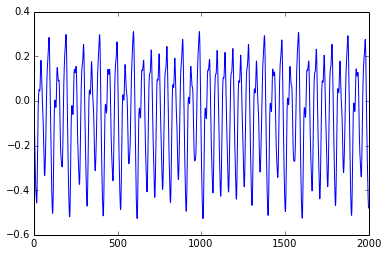

In [3]:
data = numpy.asarray(mackey_glass(2000)[0], dtype=floatX)
plt.plot(data)
plt.show()
data_train = data[:1500]
data_val = data[1500:]

To train an RNN model on this sequences, we need to generate a theano graph that computes the cost and its gradient. In this case, the task will be to predict the next time step and the error objective will be the mean squared error (MSE).  We also need to define shared variables for the output weights. Finally, we also add a regularization term to the cost.

In [4]:
w_ho_np = numpy.random.normal(0, .01, (15, 1))
w_ho = theano.shared(numpy.asarray(w_ho_np, dtype=floatX), name='w_ho')
b_o = theano.shared(numpy.zeros((1,), dtype=floatX), name='b_o')

x = T.matrix('x')
my_rnn = SimpleRNN(1, 15)
hidden = my_rnn(x)
prediction = T.dot(hidden, w_ho) + b_o
parameters = my_rnn.parameters + [w_ho, b_o]
l2 = sum((p**2).sum() for p in parameters)
mse = T.mean((prediction[:-1] - x[1:])**2)
cost = mse + .0001 * l2
gradient = T.grad(cost, wrt=parameters)

We now compile the function that will update the parameters of the model using gradient descent. 

In [5]:
lr = .3
updates = [(par, par - lr * gra) for par, gra in zip(parameters, gradient)] 
update_model = theano.function([x], cost, updates=updates)
get_cost = theano.function([x], mse)
predict = theano.function([x], prediction)
get_hidden = theano.function([x], hidden)
get_gradient = theano.function([x], gradient)

We can now train the network by supplying this function with our data and calling it repeatedly.

In [6]:
for i in range(1001):
    mse_train = update_model(data_train)
    
    if i % 100 == 0:
        mse_val = get_cost(data_val)
        print 'Epoch {}: train mse: {}    validation mse: {}'.format(i, mse_train, mse_val)

Epoch 0: train mse: 0.0509706512094    validation mse: 0.0475813224912
Epoch 100: train mse: 0.0212633032352    validation mse: 0.0203146319836
Epoch 200: train mse: 0.00217603729106    validation mse: 0.00206112954766
Epoch 300: train mse: 0.00180287752301    validation mse: 0.00165568699595
Epoch 400: train mse: 0.00157833041158    validation mse: 0.00140872935299
Epoch 500: train mse: 0.00142610061448    validation mse: 0.00123966217507
Epoch 600: train mse: 0.00131489848718    validation mse: 0.00111515459139
Epoch 700: train mse: 0.00122933008242    validation mse: 0.00101870053913
Epoch 800: train mse: 0.00116086681373    validation mse: 0.00094110466307
Epoch 900: train mse: 0.00110436568502    validation mse: 0.000876796722878
Epoch 1000: train mse: 0.00105652143247    validation mse: 0.000822182162665


Since we're only looking at a very small toy problem here, the model probably already memorized the train data quite well. Let's find out by plotting the predictions of the network:

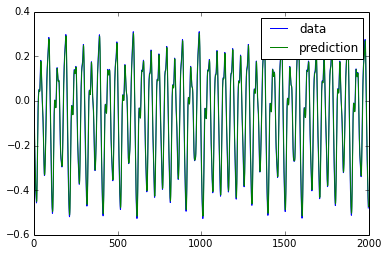

In [7]:
predict = theano.function([x], prediction)
prediction_np = predict(data)
plt.plot(data[1:], label='data')
plt.plot(prediction_np, label='prediction')
plt.legend()
plt.show()

Small scale optimizations of this type often benefit from more advanced second order methods. The following block defines some functions that allow you to experiment with off-the-shelf optimization routines. In this case we used BFGS.

In [8]:
def vector_to_params(v):
    return_list = []
    offset = 0
    # note the global variable here
    for par in parameters:
        par_size = numpy.product(par.get_value().shape)
        return_list.append(v[offset:offset+par_size].reshape(par.get_value().shape))
        offset += par_size
    return return_list
       
    
def set_params(values):
    for parameter, value in zip(parameters, values):
        parameter.set_value(numpy.asarray(value, dtype=floatX))
        
        
def f_obj(x):
    values = vector_to_params(x)
    set_params(values)
    return get_cost(data_train)
        
    
def f_prime(x):
    values = vector_to_params(x)
    set_params(values)
    grad = get_gradient(data_train)
    return numpy.asarray(numpy.concatenate([var.flatten() for var in grad]), dtype='float64')
    
    
from scipy.optimize import fmin_bfgs
x0 = numpy.asarray(numpy.concatenate([p.get_value().flatten() for p in parameters]), dtype='float64')
result = fmin_bfgs(f_obj, x0, f_prime)

print 'train mse: {}   validation mse: {}'.format(get_cost(data_train), get_cost(data_val))

         Current function value: 0.000035
         Iterations: 18
         Function evaluations: 69
         Gradient evaluations: 57
train mse: 3.46147535311e-05   validation mse: 0.000538460502867


# Generating sequences
Predicting a single step ahead is a relatively easy task. It would be more intresting to see if the network actually learned how to generate multiple time steps such that it can continue the sequence.
Write code that generates the next 1000 examples after processing the train sequence.

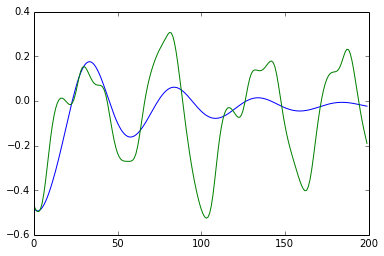

In [9]:
x_t = T.vector()
h_p = T.vector()
preactivation = T.dot(x_t, my_rnn.w_xh) + my_rnn.b_h
h_t = my_rnn._step(preactivation, h_p)
o_t = T.dot(h_t, w_ho) + b_o

single_step = theano.function([x_t, h_p], [o_t, h_t])

def generate(single_step, x_t, h_p, n_steps):
    output = numpy.zeros((n_steps, 1))
    for output_t in output:
        x_t, h_p = single_step(x_t, h_p)
        output_t[:] = x_t
    return output


output = predict(data_train)
hidden = get_hidden(data_train)

output = generate(single_step, output[-1], hidden[-1], n_steps=200)
plt.plot(output)
plt.plot(data_val[:200])
plt.show()

#Things to Try
The quality of the generated sequence is probably not very good. Let's try to improve on it. Things to consider are:
* The initial weight values
* Using L2/L1 regularization
* Using weight noise
* The number of hidden units
* The non-linearity
* Adding direct connections between the input and the output